In [31]:
### Author: Sabin, 9/6/2023
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy

## Modeling the Instability of Solid-Liquid Interface

### Introduction
Instabilities at solid-liquid interfaces during the crystallization of materials and the resulting pattern formation are of great interest due to their potential to reveal novel insights into fundamental physical processes that control material properties at the nanoscale and pave the way for innovative applications. Moreover, from an intellectual standpoint, the occurrence of pattern formation at the solid-liquid interface in a broad range of materials and the underlying universality therein presents an interesting allure.
The fundamental physics of instabilities at solid-liquid interfaces in the context of small molecules has long been known through classic works from Mullins, Sekerka, and Langer (Mullins and Sekerka, 1964; Langer, 1990). In the case of the solidification of a supercooled pure liquid, the stability of any perturbation of a planar solid-liquid interface is determined by two competing effects. Since the rate-limiting component of the solidification process is the diffusion of latent heat away from the interface, solidification will occur more rapidly at a convex solid-liquid interface due to the higher temperature gradient there, in comparison to a concave solid-liquid interface. Consequently, the fact that heat diffusion is the rate-limiting process promotes instability. On the other hand, surface tension favors a planar interface as it tends to minimize the interface area. The same principles apply to the case of diffusion-limited growth, where the concentration field of the crystallizable component behaves exactly as the temperature field in the above-described problem, while the temperature field remains essentially constant throughout the system.

The study of interface instability in the context of polymer crystallization is relatively new. Experiments on film grown crystals [Wegner et. al, 2008; Wang et. al, 2003] demonstrate  different pattern morphologies including circular spherulites, dendrites, faceted crystals, and seaweeds at different physical conditions. However, the theoretical understanding in this area remains limited. The influence of surface-energy asymmetry and the competition between diffusion-controlled and nucleation-controlled growth are considered to determine the final morphology of these patterns. A comprehensive understanding of the fundamental physics of the factors that control morphology and kinetics remains elusive. Certain aspects of growth morphology and kinetics (such as alternate tip splitting) are not well understood even within small-molecule systems.
The existing classic theories and their variants have limited applicability in exploring the intricate details of pattern formation as these models are linearized and can’t predict long-time behavior. Obtaining numerical solutions to these problems in two and three dimensions is often technically cumbersome due to the necessity of tracking the moving solid-liquid boundaries. Phase field models are generally implemented by numerical simulations as they eliminate the need for tracking the moving boundary. However, being phenomenological in nature, they often lack strong physical foundation, making it challenging to interpret the underlying mechanisms of the simulated phenomena. 

We have developed a computational technique that solves the partial differential equations governing heat and/or mass diffusion that does not require a calculation of front velocity at every local element. Using this novel approach, we solve the equations governing the interface kinetics during crystallization of small and large molecules systems under different conditions, unraveling the effects of different experimentally relevant parameters on the kinetics and morphology of pattern formation. 
In addition, our numerical approach will allow us to test the assumptions of old theories, systematically explore how the curvature, surface tension, surface tension asymmetry, diffusion limited vs nucleation limited growth pattern emerge, potentially guiding us to build new theories and crystal growth strategies. 

[This is sort of the overarching goal, but we need to start with solving something easy for the first paper. Whatever is decided to do, it will need some time, 2/3 months to get ready with a manuscript, I think.]


### Computational Method: Solidification of a supercooled liquid
Below, the method is explained through solving solidification of a supercooled liquid in 2 dimension.
#### Differential equations
1. $ \frac{\partial T}{\partial t} = \alpha(\frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2}) + \frac{L}{C} \frac{\partial \phi}{\partial t}, \phi $ is solid volume fraction.

2. A. $\frac{\partial \phi}{\partial t} = 0$ if the grid right above it is NOT fully solidified.

   B. $\frac{\partial \phi}{\partial t} = - \frac{C}{L}\alpha(\frac{\partial^2 T}{\partial x^2}+\frac{\partial^2 T}{\partial y^2})$ if the grid right above it is fully solidified. It is based on an assumption that once the solidification begins, the temperature at that grid point immediately rises to $T_s$ (once the latent heat evolved pays for the sensible heat required to heat the sample up. Numerical computation shows that this requirement does not change the result that much and is practically redundant at large latent heat), and the released latent heat is completely diffused away to the supercooled liquid region so that the temperature at the solidification site remains $T_s$.
   
The spirit of eq. 2B is the same as that of Stefan BC. Let us verify that: For simplicity, imagine a flat temperature and solidification profile along the y-axis. Then discritize the spatial derivative to get

$\frac{T_{i+1,j}+T_{i-1,j}-2T_{i,j}}{\Delta x^2} = \frac{T_{i+1,j} - T_{i,j}}{\Delta x^2} = \frac {\nabla T}{\Delta x}$
Is true if there is no temperature gradient towards the solid side. So, eqn 2B. becomes 

$\frac{\Delta \phi}{\Delta t} = - \frac{C}{L}\alpha \frac {\nabla T}{\Delta x}$ 

$\Delta\phi \frac{\Delta x}{\Delta t} = - \frac{C}{L}\alpha \nabla T$ 

$v_{interface} = - \frac{C}{L}\alpha \nabla T = - \frac{k}{\rho L} \nabla T.$

#### Boundary conditions:

1. Fixed temperatures at the top and bottom sides, PBC at the lateral sides.

In [32]:
def cdf_bulk(my_arr, pos_2d):
    '''to find 2d central difference 2nd derivative at each point except the boundry points'''
    x_pos, y_pos = pos_2d[0], pos_2d[1]
    
    d_dx2 = (1/delx**2)*(my_arr[x_pos+1, y_pos]+my_arr[x_pos-1, y_pos]-2*my_arr[x_pos, y_pos])
    d_dy2 = (1/dely**2)*(my_arr[x_pos, y_pos+1]+my_arr[x_pos, y_pos-1]-2*my_arr[x_pos, y_pos])
    
    return d_dx2+d_dy2

def cdf_boundary_right(my_arr, pos_2d):
    '''at the upper lateral boundary points using PBC'''
    x_pos, y_pos = pos_2d[0], pos_2d[1]
    
    d_dx2 = (1/delx**2)*(my_arr[x_pos+1, y_pos]+my_arr[x_pos-1, y_pos]-2*my_arr[x_pos, y_pos])
    d_dy2 = (1/dely**2)*(my_arr[x_pos, 0]+my_arr[x_pos, y_pos-1]-2*my_arr[x_pos, y_pos]) #pbc
    
    return d_dx2+d_dy2

def cdf_boundary_left(my_arr, pos_2d):
    '''at the upper lateral boundary points using PBC'''
    x_pos, y_pos = pos_2d[0], pos_2d[1]
    
    d_dx2 = (1/delx**2)*(my_arr[x_pos+1, y_pos]+my_arr[x_pos-1, y_pos]-2*my_arr[x_pos, y_pos])
    d_dy2 = (1/dely**2)*(my_arr[x_pos, 1]+my_arr[x_pos, y_pos-1]-2*my_arr[x_pos, y_pos]) #pbc
    
    return d_dx2+d_dy2

## The two lateral ends are connected, so the points at the edge are exactly the same, so grids at one of the edge are just
## place holders - I compute the right edge, and immediately copy that to the left edge. Caution: make sure their values are 
## the same when applying the perturbation as well

In [33]:
# Parameters

#alpha = 1
lam = 5.0 #L/C(T_solid-T_liquid)

delx = 0.1
dely = delx
delt = (delx**2)/4

T_solid = 0 # solid temperature on the left, melting temperature
T_liquid = -1 # liquid temperature on the right, supercooled

In [34]:
# Initial configuration
length = 500 # no. of grids along length
width = 10 # along width

temp_array = np.zeros((length, width)) # initialize temperature array
initial_boundary0 = 20*delx # ref

L_x = (width-1)*delx #physical width
n_wave = 10
amp = 0*delx
k = ((2*np.pi)/L_x)*n_wave

x_position = np.arange(0, L_x+delx, delx)
initial_boundary = initial_boundary0+amp*np.sin(k*x_position)

print(initial_boundary)

#temp_drop_range = 1 # temp linearly goes from L_solid to L_liquid across five grid points

for j in range(width):
    for i in range(length):
        y_position = i*delx
        if y_position <= initial_boundary[j]:
            temp_array[i,j] = T_solid
        else:
            temp_array[i,j] = T_liquid
            
#        else:
#            grid_distance = (y_position - initial_boundary[j])/(temp_drop_range*delx)
#            if grid_distance <= 1:
#                temp_array[i,j] = T_solid - (T_solid-T_liquid)*(y_position - initial_boundary[j])/(temp_drop_range*delx)
#            else:
#                temp_array[i,j] = T_liquid
                
        
        
#print(temp_array)

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


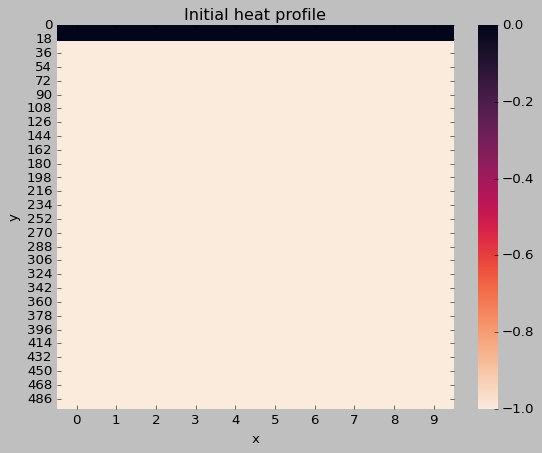

In [35]:
# heat map
# diffuse temperature boundary - initial condition
ax = sns.heatmap(temp_array, cmap = sns.cm.rocket_r)
plt.title('Initial heat profile')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [36]:
phi_array = np.zeros((length, width))

for i in range(length):
    for j in range(width):
        temp = temp_array[i,j]
        if temp == T_solid:
            phi_array[i,j] = 1     

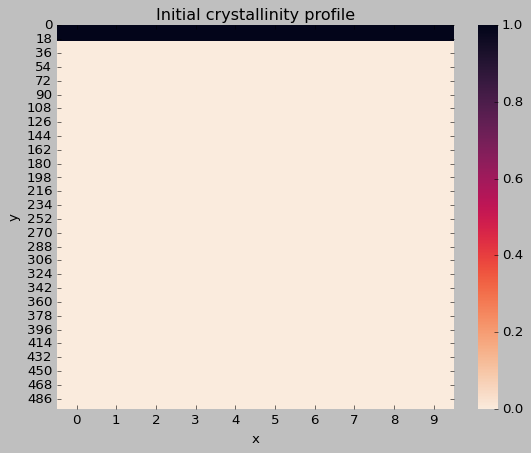

In [37]:
# plot initial liquid fraction
ax = sns.heatmap(phi_array, cmap = sns.cm.rocket_r)
plt.title('Initial crystallinity profile')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [38]:
## Now find time evolution
#print(temp_array.shape)

temp_profiles_list = [temp_array]
phi_profiles_list = [phi_array]

phi_array[20,0]

1.0

In [39]:
new_constant = 1.0/lam
total_time_steps = 20000

#x_position = np.arange(0, L_x+delx, delx)
boundary = [initial_boundary]
time_lis = [0]
int_boundary = [0]
smooth_boundary = [0]

for t in range(1,total_time_steps+1):
    #print(t)
    time_lis.append(t*delt)
    #initialize dphi_dt array
    dphi_dt_array = np.zeros((length, width))
    dT_dt_array = np.zeros((length, width))
    temp_gap = np.zeros((length, width))
    phi0 = np.zeros((length, width))
    
    #Calculate temp gap
    for i in range(1, length-1):
        for j in range(0, width):
            if phi_array[i-1, j] == 1 and phi_array[i, j] == 0:
                temp_gap[i,j] = T_solid - temp_array[i, j]
                phi0[i,j] = temp_gap[i,j]*new_constant
            
    ## bulk
    for i in range(1,length-1):
        for j in range(width):
            if phi_array[i-1, j] == 1 and phi_array[i, j] < 1:
                #print(i)
                temp_array[i, j] = T_solid
                
    for i in range(1, length-1):
        for j in range(1, width-1):
            if phi_array[i-1, j] == 1 and phi_array[i, j] < 1:
                dphi_dt_array[i,j] = -1/lam*cdf_bulk(temp_array, [i,j]) # + temp_gap[i,j]*new_constant/delt
            else:
                dT_dt_array[i,j] = cdf_bulk(temp_array, [i,j]) 
                
        ## lateral
    for i in range(1, length-1):
        if phi_array[i-1, 0] == 1 and phi_array[i, 0] < 1:
            dphi_dt_array[i,0] = -1/lam*cdf_boundary_left(temp_array, [i,0]) #+ temp_gap[i,0]*new_constant/delt
        else:
            dT_dt_array[i,0] = cdf_boundary_left(temp_array, [i,0])
                
        if phi_array[i-1, width-1] == 1 and phi_array[i, width-1] < 1:
            dphi_dt_array[i, width-1] = -1/lam*cdf_boundary_right(temp_array, [i,width-1]) #+ temp_gap[i,width-1]*new_constant/delt
        else:
            dT_dt_array[i,width-1] = cdf_boundary_right(temp_array, [i, width-1])
                
    temp_array = temp_array + delt*dT_dt_array
    phi_array = phi_array + delt*dphi_dt_array + phi0
    
    for i in range(1, length-1):
        for j in range(width):
            if phi_array[i,j] > 1:
                phi_array[i,j]=1

                
    boundary_list = []
    
    for j in range(width):
        seq = phi_array[:,j]
        for ind, elem in enumerate(seq):
            if elem < 1:
                boundary_list.append((ind-1)*delx)
                current_phi = elem
                break
    if t%10 == 0:          
        boundary.append(boundary_list)
        
    int_boundary.append(boundary_list[0]-initial_boundary0)
    smooth_boundary.append(boundary_list[0]-initial_boundary0 + elem*delx)

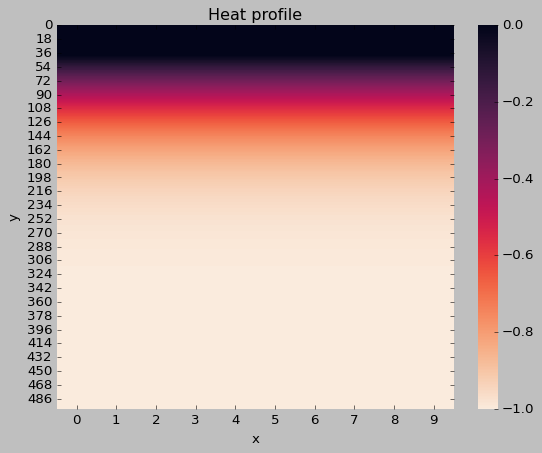

In [40]:
ax = sns.heatmap(temp_array, cmap = sns.cm.rocket_r)
plt.title('Heat profile')
plt.xlabel('x')
plt.ylabel('y')

plt.show()

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


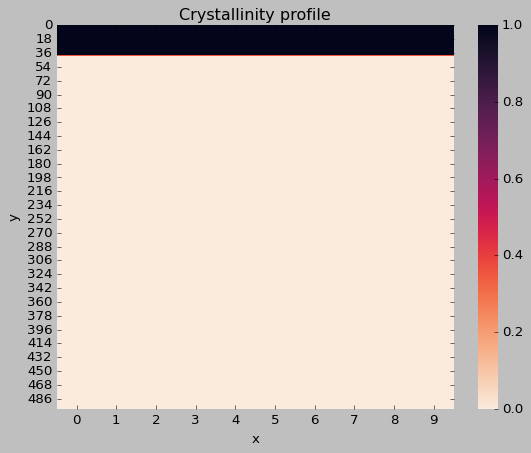

In [41]:
ax = sns.heatmap(phi_array, cmap = sns.cm.rocket_r)
print(phi_array[21])
print(phi0[21])
#print(delt*dphi_dt_array[21])
plt.title('Crystallinity profile')
plt.xlabel('x')
plt.ylabel('y')

plt.show()

Text(0, 0.5, 'y')

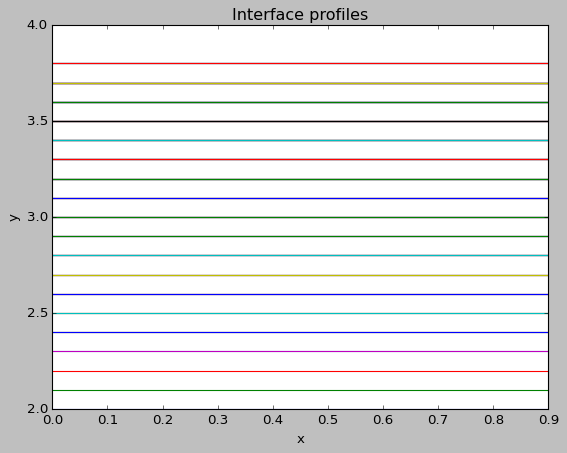

In [42]:
for elem in boundary[::20]:
    #print(elem)
    plt.plot(x_position, elem)
    
plt.title('Interface profiles')
plt.xlabel('x')
plt.ylabel('y')


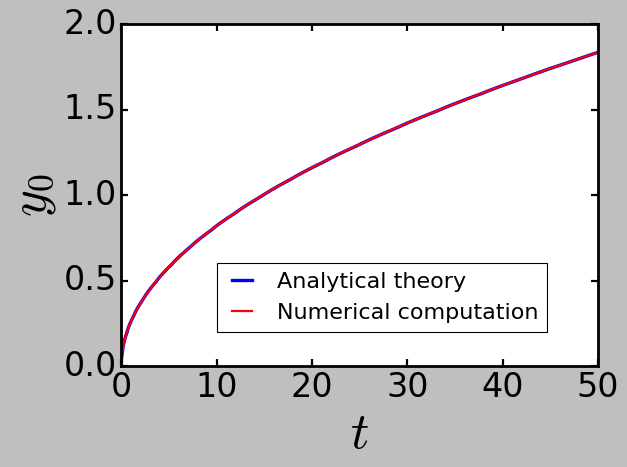

In [43]:
import matplotlib as mpl
#mpl.rcParams['mathtext.fontset'] = 'cm'

ax = plt.axes()

#print(dphi_dt_array)
lam = 0.1298
#lam = 0.465*0.95
#lam = 0.58*2.5


def f(ti):
    return lam*(4*ti)**0.5
    
#plt.plot(time_lis, int_boundary, color = 'b', linewidth = 1)
plt.plot(time_lis, smooth_boundary, color = 'b', linewidth = 3)
#plt.legend({'simulation'})
plt.plot(time_lis, [f(ti) for ti in time_lis], color = 'r', linewidth = 2)

plt.legend(( 'Analytical theory',  'Numerical computation' ),
          shadow=False, loc=(0.20, 0.1), handlelength=1.5, fontsize=20)
#plt.plot(time_lis, smooth_boundary, color = 'b', linestyle = '--')
#plt.legend({'a', 'b'})
ax.set_xlabel(r'$t$', {'fontsize': 46})
ax.set_ylabel(r'$y_{0}$', { 'fontsize': 46})

ax.tick_params(axis='both', which='major', labelsize=30)
plt.setp(ax.spines.values(), linewidth=2.5)
ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 6, width = 2)
#plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
 
plt.style.use('classic')
ax.xaxis.offsetText.set_fontsize(16)
plt.tight_layout()
plt.style.use('classic')

plt.savefig('second_stefan-lambda=5')
plt.show()

The above plot shows the evolution of solid-liquid interface in the second Stefan problem with S=5. Perfectly overlapping curves showing excellent match. Next, we perturb the interface and explore its instability.